In [1]:
import matplotlib.pyplot as plt
import random
from __future__ import print_function
from pathlib import Path
from random import shuffle
import random

import argparse
import copy
import networkx as nx
import numpy as np
import sys
import tensorflow as tf
import igraph as ig

from deeplp.models.data_prep import create_weighted_graph, load_data
from deeplp.models.data_prep import prepare_data, random_unlabel, calc_masks
from deeplp.models.deeplp_att import DeepLP_ATT
from deeplp.models.deeplp_edge import DeepLP_Edge
from deeplp.models.deeplp_wrbf import DeepLP_WRBF
from deeplp.models.lp import LP
from deeplp.models.utils import accuracy, indices_to_vec
from deeplp.models.data_prep import select_features
from datasets import utils

/Users/kojin/anaconda/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
true_labels, features, edge_features, node_features, graph \
= load_data('cora','linqs',directed=1,confidence=0)
U,D,B,R,node_features = utils.load_data('cora','linqs','datasets')
edges = np.array(B.edges())
sources,sinks = edges[:,0],edges[:,1]
labeled_indices, unlabeled_indices = \
        random_unlabel(true_labels,0.9,features,
                       seed=0,confidence=0)

-----------cora-----------
Loading labels...
Loading features...
Loading edge features...
Weights: Asymmetric
Loading graph...
Done!


In [4]:
a

[(0,
  3,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  13,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  27,
  27,
  27,
  27,
  28,
  29,
  29,
  33,
  35,
  35,
  35,
  35,
  36,
  36,
  36,
  36,
  37,
  38,
  45,
  48,
  49,
  49,
  50,
  50,
  53,
  53,
  54,
  54,
  55,
  55,
  56,
  56,
  62,
  66,
  68,
  73,
  73,
  73,
  73,
  74,
  76,
  77,
  77,
  84,
  84,
  90,
  98,
  98,
  106,
  111,
  114,
  115,
  121,
  121,
  130,
  131,
  135,
  140,
  141,
  143,
  145,
  145,
  147,
  147,
  154,
  156,
  156,
  157,
  157,
  158,
  158,
  162,
  169,
  170,
  172,
  175,
  175,
  176,
  176,
  176,
  176,
  176,
  180,
  181,
  183,
  193,
  194,
  196,
  196,
  197,
  197,
  201,
  202,
  203,
  203,
  203,
  203,
  204,
  204,
  204,
  204,
  205,
  208,
  213,
  214,
  218,
  220,
  220,
  221,
  221,
  221,
  222,
  237,
  237,
  239,
  240,
  244,
  244,
  245,
  246,
  247,
  247,
  248,
  249,
  249,
  250,
 

In [129]:
Gsub.nodes

NodeView((1, 2, 4, 5, 6, 11, 17, 18, 23, 27, 28, 32, 36, 39, 42, 43, 44, 45, 50, 59, 60, 63, 64, 66, 69, 70, 71, 75, 76, 77, 79, 85, 87, 96, 101, 102, 104, 106, 107, 108, 110, 114, 116, 117, 123, 124, 125, 126, 129, 140, 144, 146, 148, 152, 153, 154, 162, 164, 167, 173, 181, 183, 185, 187, 188, 190, 193, 196, 201, 202, 206, 208, 209, 213, 222, 224, 228, 229, 234, 235, 240, 244, 258, 259, 261, 262, 263, 264, 271, 273, 283, 284, 286, 287, 288, 289, 291, 298, 308, 314, 315, 319, 320, 324, 327, 331, 332, 339, 340, 341, 346, 359, 360, 361, 362, 365, 366, 367, 373, 375, 376, 378, 386, 387, 389, 403, 408, 414, 415, 416, 424, 428, 429, 434, 438, 439, 440, 441, 443, 444, 445, 452, 455, 456, 457, 458, 460, 461, 465, 466, 467, 468, 469, 477, 483, 484, 485, 487, 489, 491, 492, 493, 495, 501, 503, 506, 514, 518, 519, 521, 525, 526, 529, 530, 531, 532, 540, 541, 542, 543, 544, 545, 548, 550, 551, 552, 555, 557, 558, 559, 560, 563, 576, 577, 583, 584, 595, 597, 599, 600, 601, 602, 603, 604, 605, 606,

505 505


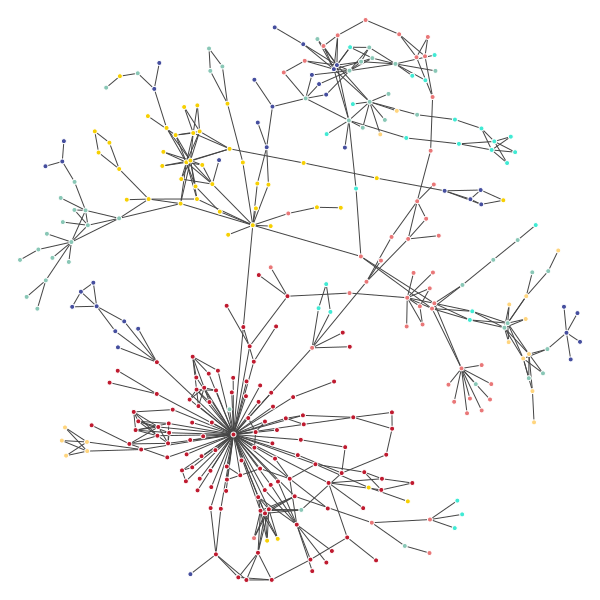

In [102]:
rand_nodes = np.sort(np.random.choice(np.arange(true_labels.shape[0]),1000))
org_to_node = {}
for i,node in enumerate(rand_nodes):
    org_to_node[node] = i

G = nx.from_scipy_sparse_matrix(graph[rand_nodes][:,rand_nodes])
Gsub = max(nx.connected_component_subgraphs(G), key=len)
a = list(zip(*nx.to_edgelist(Gsub)))[:2]

nodes_to_id = {}
for i,node in enumerate(Gsub.nodes):
    nodes_to_id[node] = i
final_nodes = rand_nodes[list(nodes_to_id)]

final_edges = []
for col in a:
    edges_col = []
    for el in col:
        edges_col.append(nodes_to_id[el])
    final_edges.append(edges_col)
print(len(a[0]),len(final_edges[0]))
g1 = ig.Graph(len(Gsub), list(zip(*final_edges)))



color_list = {
    0: '#E97778',
    1: '#bf1a2f',
    2: '#454e9e',
    6: '#89C7B6',
    4: '#f7d002',
    5: '#41ead4',
    3: '#FFD57E'
}
colors = [color_list[label] for label in np.argmax(true_labels[final_nodes],axis=1)]
colors = np.array(colors)

layout = g1.layout()
ig.plot(g1,layout=layout, vertex_size=5, vertex_color=colors,vertex_frame_color='white')

In [103]:
org=np.loadtxt('org.csv',delimiter=',')
opt=np.loadtxt('opt.csv',delimiter=',')

In [104]:
masterG = nx.from_scipy_sparse_matrix(graph)
edges = nx.to_edgelist(masterG)

In [105]:
sub_edges = [set(r[:2]) for r in list(nx.to_edgelist(Gsub))]

In [113]:
sub_opt = []
for el,edge in zip(opt,edges): 
    r,c = edge[:2]
    if r in org_to_node and c in org_to_node:
        if org_to_node[r] in final_edges and org_to_node[c] in final_edges:
            sub_opt.append(el)

In [114]:
len(sub_opt)

0

In [108]:
id_to_org = {}
for org in final_nodes:
    id_to_org[nodes_to_id[org_to_node[org]]] = org

505

In [135]:
list(zip(*final_edges))

[(0, 1),
 (0, 142),
 (0, 145),
 (0, 314),
 (2, 27),
 (2, 301),
 (2, 300),
 (3, 27),
 (3, 165),
 (4, 10),
 (4, 9),
 (4, 31),
 (4, 43),
 (4, 42),
 (4, 55),
 (4, 171),
 (4, 237),
 (4, 246),
 (5, 211),
 (6, 160),
 (6, 159),
 (6, 161),
 (6, 217),
 (7, 12),
 (7, 30),
 (7, 223),
 (8, 160),
 (8, 159),
 (8, 216),
 (8, 232),
 (8, 234),
 (8, 233),
 (9, 133),
 (9, 148),
 (9, 276),
 (9, 275),
 (9, 330),
 (10, 133),
 (10, 148),
 (10, 276),
 (10, 275),
 (10, 330),
 (11, 103),
 (11, 104),
 (13, 158),
 (14, 207),
 (14, 206),
 (14, 208),
 (15, 207),
 (15, 206),
 (15, 208),
 (16, 207),
 (16, 206),
 (16, 208),
 (17, 181),
 (17, 180),
 (18, 247),
 (19, 225),
 (19, 280),
 (20, 225),
 (20, 280),
 (21, 87),
 (21, 86),
 (21, 103),
 (22, 87),
 (22, 86),
 (22, 214),
 (22, 280),
 (22, 311),
 (23, 239),
 (23, 301),
 (23, 300),
 (24, 179),
 (25, 179),
 (26, 179),
 (28, 305),
 (28, 304),
 (29, 101),
 (29, 245),
 (30, 101),
 (31, 107),
 (32, 122),
 (32, 208),
 (32, 280),
 (33, 325),
 (34, 102),
 (35, 102),
 (36, 158)

In [134]:
len(final_nodes)

331

In [126]:
final_org_edges = []
for edge in list(np.array(final_edges).T):
    final_org_edges.append([id_to_org[edge[0]],id_to_org[edge[1]]])

KeyError: 300

In [127]:
id_to_org

{0: 5,
 1: 6,
 2: 9,
 3: 10,
 4: 15,
 5: 30,
 6: 38,
 7: 42,
 8: 52,
 10: 57,
 11: 71,
 12: 80,
 13: 86,
 16: 92,
 17: 98,
 18: 110,
 20: 132,
 21: 138,
 22: 139,
 23: 145,
 26: 153,
 27: 165,
 28: 169,
 29: 171,
 30: 179,
 31: 188,
 32: 200,
 33: 237,
 35: 247,
 36: 253,
 37: 257,
 38: 258,
 39: 262,
 40: 266,
 41: 276,
 43: 279,
 44: 291,
 45: 293,
 46: 300,
 47: 304,
 48: 313,
 49: 341,
 50: 353,
 51: 360,
 52: 366,
 53: 375,
 54: 383,
 55: 384,
 56: 417,
 57: 421,
 58: 429,
 59: 443,
 60: 465,
 61: 471,
 62: 477,
 63: 482,
 64: 483,
 65: 485,
 66: 497,
 67: 505,
 69: 526,
 70: 533,
 71: 540,
 72: 541,
 73: 554,
 74: 586,
 75: 594,
 76: 608,
 77: 609,
 78: 617,
 79: 622,
 80: 633,
 81: 642,
 83: 676,
 85: 682,
 87: 683,
 88: 703,
 89: 718,
 90: 739,
 91: 743,
 94: 755,
 95: 760,
 96: 771,
 97: 792,
 98: 812,
 100: 826,
 101: 840,
 102: 844,
 103: 855,
 104: 861,
 106: 864,
 107: 876,
 108: 882,
 109: 885,
 110: 907,
 111: 930,
 112: 931,
 114: 934,
 117: 942,
 118: 959,
 119: 964,
 

In [110]:
np.sum(graph.toarray()[final_nodes][:,final_nodes])/2

505.0

In [122]:
id_to_org

{0: 5,
 1: 6,
 2: 9,
 3: 10,
 4: 15,
 5: 30,
 6: 38,
 7: 42,
 8: 52,
 10: 57,
 11: 71,
 12: 80,
 13: 86,
 16: 92,
 17: 98,
 18: 110,
 20: 132,
 21: 138,
 22: 139,
 23: 145,
 26: 153,
 27: 165,
 28: 169,
 29: 171,
 30: 179,
 31: 188,
 32: 200,
 33: 237,
 35: 247,
 36: 253,
 37: 257,
 38: 258,
 39: 262,
 40: 266,
 41: 276,
 43: 279,
 44: 291,
 45: 293,
 46: 300,
 47: 304,
 48: 313,
 49: 341,
 50: 353,
 51: 360,
 52: 366,
 53: 375,
 54: 383,
 55: 384,
 56: 417,
 57: 421,
 58: 429,
 59: 443,
 60: 465,
 61: 471,
 62: 477,
 63: 482,
 64: 483,
 65: 485,
 66: 497,
 67: 505,
 69: 526,
 70: 533,
 71: 540,
 72: 541,
 73: 554,
 74: 586,
 75: 594,
 76: 608,
 77: 609,
 78: 617,
 79: 622,
 80: 633,
 81: 642,
 83: 676,
 85: 682,
 87: 683,
 88: 703,
 89: 718,
 90: 739,
 91: 743,
 94: 755,
 95: 760,
 96: 771,
 97: 792,
 98: 812,
 100: 826,
 101: 840,
 102: 844,
 103: 855,
 104: 861,
 106: 864,
 107: 876,
 108: 882,
 109: 885,
 110: 907,
 111: 930,
 112: 931,
 114: 934,
 117: 942,
 118: 959,
 119: 964,
 